In [52]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from timm import create_model
import argparse
from torchvision import transforms
import tifffile as tiff
import math
from PIL import Image
import matplotlib.cm as cm
import torch.nn as nn
import torch.nn.functional as F


class EnhancedAttentionVisualizer:
    """
    A more robust visualizer that can capture attention patterns from different Swin implementations.
    Uses multiple detection strategies and provides detailed debugging.
    """
    def __init__(self, model, discard_ratio=0.9):
        self.model = model
        self.discard_ratio = discard_ratio
        self.hooks = []
        self.attention_data = {}  # Dictionary to store attention data by layer name
        self.feature_maps = {}    # Dictionary to store feature maps as fallback
        self.activations = {}     # Dictionary to store activation maps
        self.qkv_data = {}        # Dictionary to store Q, K, V data if available
        
        # Track model internals
        self.module_dict = dict(model.named_modules())
        
        # Register hooks for all potential attention layers and feature extraction
        self._register_hooks()
    
    def _register_hooks(self):
        """Register hooks for attention and feature extraction using multiple strategies"""
        # Count how many hooks we register
        hook_count = 0
        
        # First, dump model structure to understand what's available
        print("\nModel structure summary:")
        for name, module in self.model.named_modules():
            # Only print top-level modules and potential attention modules to avoid clutter
            if len(name.split('.')) <= 2 or 'attn' in name.lower():
                module_type = type(module).__name__
                print(f"  {name}: {module_type}")
                
                # Print attention-related attributes if present
                if hasattr(module, 'attn') or hasattr(module, 'qkv') or hasattr(module, 'qkv_bias'):
                    attrs = [attr for attr in dir(module) if not attr.startswith('_') and not callable(getattr(module, attr))]
                    attention_attrs = [attr for attr in attrs if any(kw in attr.lower() for kw in ['attn', 'qkv', 'head'])]
                    if attention_attrs:
                        print(f"    Attention attributes: {', '.join(attention_attrs)}")
                        
                # Print module methods that might be related to attention
                methods = [m for m in dir(module) if callable(getattr(module, m)) and not m.startswith('_') 
                          and any(kw in m.lower() for kw in ['attn', 'forward', 'get'])]
                if 'forward' in methods:
                    methods.remove('forward')  # Don't show forward as it's in every module
                if methods:
                    print(f"    Methods: {', '.join(methods)}")
        
        # Try to find different types of attention implementation
        print("\nRegistering attention hooks:")
        
        # Strategy 1: Look for WindowAttention modules (common in Swin implementations)
        for name, module in self.model.named_modules():
            module_type = type(module).__name__
            
            # Check for WindowAttention or similar module types
            if 'WindowAttention' in module_type or 'window_attn' in name.lower() or 'win_attn' in name.lower():
                print(f"  Found Window Attention module: {name} ({module_type})")
                
                # Add hook for QKV computation or attention output
                if hasattr(module, 'forward'):
                    self.hooks.append(module.register_forward_hook(self._window_attention_hook(name)))
                    hook_count += 1
                    print(f"    Registered hook for {name}")
            
            # Strategy 2: Look for modules with attention in the name
            elif 'attn' in name.lower() and not any(skip in name.lower() for skip in ['dropout', 'norm']):
                print(f"  Found potential attention module: {name} ({module_type})")
                
                # Determine which type of hook to use based on attributes
                if hasattr(module, 'attn'):
                    self.hooks.append(module.register_forward_hook(self._direct_attention_hook(name)))
                    hook_count += 1
                    print(f"    Registered direct attention hook for {name}")
                elif hasattr(module, 'qkv') or hasattr(module, 'q_proj'):
                    self.hooks.append(module.register_forward_hook(self._qkv_attention_hook(name)))
                    hook_count += 1
                    print(f"    Registered QKV attention hook for {name}")
                else:
                    # Generic forward hook as fallback
                    self.hooks.append(module.register_forward_hook(self._generic_attention_hook(name)))
                    hook_count += 1
                    print(f"    Registered generic attention hook for {name}")
            
            # Strategy 3: Capture feature maps from all convolutional and linear layers as fallback
            elif isinstance(module, (nn.Conv2d, nn.Linear)) and not 'head' in name.lower():
                # For these, we're just capturing activations as fallback
                self.hooks.append(module.register_forward_hook(self._feature_hook(name)))
                hook_count += 1
        
        print(f"\nRegistered {hook_count} hooks in total")
        
        if hook_count == 0:
            print("WARNING: No suitable attention modules found! Visualization may not work.")
    
    def _window_attention_hook(self, name):
        """Hook specifically designed for WindowAttention modules in Swin"""
        def hook(module, inputs, outputs):
            try:
                # Try to access attention weights - there are different ways depending on implementation
                if hasattr(module, 'attn'):
                    # Some implementations store attention directly
                    attn = module.attn.detach().cpu()
                    self.attention_data[name] = attn
                    print(f"Captured window attention from {name}: {attn.shape}")
                elif hasattr(module, 'get_attn_weights'):
                    # Some have a method to get attention weights
                    attn = module.get_attn_weights().detach().cpu()
                    self.attention_data[name] = attn
                    print(f"Captured window attention from {name}: {attn.shape}")
                else:
                    # Try to compute attention from inputs and outputs
                    # This varies by implementation, here's a common pattern
                    if len(inputs) >= 3:
                        q, k, v = inputs[0], inputs[1], inputs[2]
                        # Store QKV for manual attention computation
                        self.qkv_data[name] = {
                            'q': q.detach().cpu(),
                            'k': k.detach().cpu(),
                            'v': v.detach().cpu()
                        }
                        print(f"Captured QKV data from {name}")
                    
                    # Also store the output as it may contain attention information
                    if isinstance(outputs, tuple) and len(outputs) > 1:
                        # Some implementations return (output, attention)
                        self.activations[name] = outputs[0].detach().cpu()
                        if len(outputs) > 1:  # Sometimes second element is attention weights
                            self.attention_data[name] = outputs[1].detach().cpu()
                            print(f"Captured attention from outputs[1] of {name}: {outputs[1].shape}")
                    else:
                        # Store output activation
                        self.activations[name] = outputs.detach().cpu()
            except Exception as e:
                print(f"Error in window attention hook for {name}: {e}")
        return hook
    
    def _direct_attention_hook(self, name):
        """Hook for modules with direct 'attn' attribute"""
        def hook(module, inputs, outputs):
            try:
                attn = module.attn.detach().cpu()
                self.attention_data[name] = attn
                print(f"Captured direct attention from {name}: {attn.shape}")
            except Exception as e:
                print(f"Error in direct attention hook for {name}: {e}")
                # Fallback to storing outputs
                if isinstance(outputs, tuple):
                    self.activations[name] = outputs[0].detach().cpu()
                else:
                    self.activations[name] = outputs.detach().cpu()
        return hook
    
    def _qkv_attention_hook(self, name):
        """Hook for modules with QKV computation"""
        def hook(module, inputs, outputs):
            try:
                # Try to capture Q, K, V for manual attention computation
                if hasattr(module, 'qkv'):
                    # Handle case where QKV is computed together
                    x = inputs[0]
                    qkv = module.qkv(x)
                    batch_size = qkv.shape[0]
                    
                    # Different implementations split QKV differently
                    # Here's a common pattern, may need adjustment
                    if hasattr(module, 'num_heads') and hasattr(module, 'head_dim'):
                        num_heads = module.num_heads
                        head_dim = module.head_dim
                        qkv = qkv.reshape(batch_size, -1, 3, num_heads, head_dim)
                        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, H, N, D)
                        q, k, v = qkv[0], qkv[1], qkv[2]
                        
                        # Store for later attention computation
                        self.qkv_data[name] = {
                            'q': q.detach().cpu(),
                            'k': k.detach().cpu(),
                            'v': v.detach().cpu()
                        }
                        print(f"Captured QKV data from {name}")
                        
                        # Try to compute attention weights directly
                        try:
                            k_t = k.transpose(-2, -1)
                            attn = (q @ k_t) * module.scale
                            attn = attn.softmax(dim=-1)
                            self.attention_data[name] = attn.detach().cpu()
                            print(f"Computed attention weights for {name}: {attn.shape}")
                        except Exception as e:
                            print(f"Failed to compute attention weights for {name}: {e}")
                
                elif hasattr(module, 'q_proj') and hasattr(module, 'k_proj') and hasattr(module, 'v_proj'):
                    # Handle case where Q, K, V are computed separately
                    x = inputs[0]
                    q = module.q_proj(x)
                    k = module.k_proj(x)
                    v = module.v_proj(x)
                    
                    # Store for later attention computation
                    self.qkv_data[name] = {
                        'q': q.detach().cpu(),
                        'k': k.detach().cpu(),
                        'v': v.detach().cpu()
                    }
                    print(f"Captured separate Q, K, V from {name}")
                    
                    # Try to compute attention weights
                    try:
                        if hasattr(module, 'scale'):
                            scale = module.scale
                        else:
                            scale = 1.0 / math.sqrt(q.size(-1))
                            
                        # Reshape if necessary
                        if hasattr(module, 'reshape_for_attention'):
                            q, k, v = module.reshape_for_attention(q, k, v)
                        
                        # Compute attention
                        k_t = k.transpose(-2, -1)
                        attn = (q @ k_t) * scale
                        attn = attn.softmax(dim=-1)
                        self.attention_data[name] = attn.detach().cpu()
                        print(f"Computed attention weights for {name}: {attn.shape}")
                    except Exception as e:
                        print(f"Failed to compute attention weights for {name}: {e}")
                
                # Also store output
                if isinstance(outputs, tuple):
                    self.activations[name] = outputs[0].detach().cpu()
                else:
                    self.activations[name] = outputs.detach().cpu()
                    
            except Exception as e:
                print(f"Error in QKV attention hook for {name}: {e}")
        return hook
    
    def _generic_attention_hook(self, name):
        """Generic hook for potential attention layers"""
        def hook(module, inputs, outputs):
            try:
                # Store output
                if isinstance(outputs, tuple):
                    self.activations[name] = outputs[0].detach().cpu()
                    # If second element exists, it might be attention
                    if len(outputs) > 1:
                        self.attention_data[name] = outputs[1].detach().cpu()
                        print(f"Captured potential attention from outputs[1] of {name}: {outputs[1].shape}")
                else:
                    self.activations[name] = outputs.detach().cpu()
                    
                # Also try to find attention in the module
                for attr_name in dir(module):
                    if 'attn' in attr_name.lower() and not attr_name.startswith('_'):
                        attr = getattr(module, attr_name)
                        if isinstance(attr, torch.Tensor):
                            self.attention_data[f"{name}.{attr_name}"] = attr.detach().cpu()
                            print(f"Captured attention from {name}.{attr_name}: {attr.shape}")
            except Exception as e:
                print(f"Error in generic hook for {name}: {e}")
        return hook
    
    def _feature_hook(self, name):
        """Hook to capture feature maps as fallback"""
        def hook(module, inputs, outputs):
            # Store feature maps without printing to avoid clutter
            if isinstance(outputs, tuple):
                self.feature_maps[name] = outputs[0].detach().cpu()
            else:
                self.feature_maps[name] = outputs.detach().cpu()
        return hook
    
    def remove_hooks(self):
        """Remove all hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
    
    def __call__(self, input_tensor):
        """Run forward pass and capture attention"""
        # Clear previous data
        self.attention_data = {}
        self.feature_maps = {}
        self.activations = {}
        self.qkv_data = {}
        
        # Forward pass
        with torch.no_grad():
            _ = self.model(input_tensor)
        
        # Check if we got any attention data
        if not self.attention_data:
            print("\nNo direct attention maps were captured.")
            
            # Try to compute attention from QKV if available
            if self.qkv_data:
                print("Attempting to compute attention from QKV data...")
                self._compute_attention_from_qkv()
            
            # If still no attention data, use activations or feature maps as fallback
            if not self.attention_data:
                print("Using activation maps as fallback...")
                # Use activation patterns from late-stage layers as proxy for attention
                for name, activation in self.activations.items():
                    # Only use activations from non-embedding layers
                    if 'embed' not in name.lower() and activation.dim() >= 3:
                        print(f"Using activation from {name} as attention proxy: {activation.shape}")
                        # Use the mean across channels as an attention proxy
                        if activation.dim() == 4:  # [B, C, H, W]
                            attention_proxy = activation.mean(dim=1, keepdim=True)
                            self.attention_data[name] = attention_proxy
                        elif activation.dim() == 3:  # [B, N, C]
                            # For sequence data, use the norm across feature dim
                            attention_proxy = torch.norm(activation, dim=2, keepdim=True)
                            self.attention_data[name] = attention_proxy
                
                # If still no attention data, use feature maps
                if not self.attention_data:
                    print("Using feature maps as final fallback...")
                    # Use a few representative feature maps
                    feature_names = sorted(self.feature_maps.keys())
                    # Select some distributed feature maps (if available)
                    if len(feature_names) > 4:
                        indices = [len(feature_names)//5, 2*len(feature_names)//5, 
                                  3*len(feature_names)//5, 4*len(feature_names)//5]
                        selected_features = [feature_names[i] for i in indices]
                    else:
                        selected_features = feature_names
                    
                    for name in selected_features:
                        feature = self.feature_maps[name]
                        if feature.dim() == 4:  # [B, C, H, W]
                            # Use channel mean as attention proxy
                            attention_proxy = feature.mean(dim=1, keepdim=True)
                            self.attention_data[name] = attention_proxy
                            print(f"Using feature map from {name} as attention proxy: {feature.shape}")
        
        return self.attention_data
    
    def _compute_attention_from_qkv(self):
        """Try to compute attention weights from stored Q, K, V data"""
        for name, qkv in self.qkv_data.items():
            try:
                q, k, v = qkv['q'], qkv['k'], qkv['v']
                
                # Check dimensions
                if q.dim() >= 3 and k.dim() >= 3:
                    # Compute attention weights
                    # For multi-head attention, the dimensions might be [B, num_heads, seq_len, head_dim]
                    if q.dim() == 4 and k.dim() == 4:
                        # Compute attention per head
                        k_t = k.transpose(-2, -1)
                        attn = torch.matmul(q, k_t)
                        
                        # Scale attention scores
                        head_dim = q.size(-1)
                        attn = attn / math.sqrt(head_dim)
                        
                        # Apply softmax
                        attn = F.softmax(attn, dim=-1)
                        
                        self.attention_data[name] = attn
                        print(f"Computed attention from QKV for {name}: {attn.shape}")
                    elif q.dim() == 3 and k.dim() == 3:
                        # Standard sequence attention [B, seq_len, dim]
                        k_t = k.transpose(-2, -1)
                        attn = torch.matmul(q, k_t)
                        
                        # Scale attention scores
                        dim = q.size(-1)
                        attn = attn / math.sqrt(dim)
                        
                        # Apply softmax
                        attn = F.softmax(attn, dim=-1)
                        
                        self.attention_data[name] = attn
                        print(f"Computed attention from QKV for {name}: {attn.shape}")
            except Exception as e:
                print(f"Failed to compute attention from QKV for {name}: {e}")
    
    def visualize(self, input_tensor, original_image, save_path=None, max_maps=6):
        """Visualize attention maps"""
        # Get attention data
        attention_data = self.__call__(input_tensor)
        
        if not attention_data:
            print("No attention data available for visualization.")
            return
        
        # Calculate number of attention maps to display
        num_maps = min(len(attention_data), max_maps)
        
        # Select a representative subset of attention maps if we have too many
        if len(attention_data) > max_maps:
            # Try to get a diverse set of maps from different parts of the network
            # Sort by name, then take evenly spaced samples
            sorted_names = sorted(attention_data.keys())
            indices = np.linspace(0, len(sorted_names) - 1, num_maps, dtype=int)
            selected_names = [sorted_names[i] for i in indices]
        else:
            selected_names = list(attention_data.keys())
        
        # Create figure
        fig_width = min(15, 3 * (num_maps + 1))  # Limit width
        fig, axes = plt.subplots(1, num_maps + 1, figsize=(fig_width, 4))
        
        # If only one axis, wrap in list
        if num_maps == 0:
            axes = [axes]
        
        # Create false color visualization for multispectral image
        if len(original_image.shape) == 3 and original_image.shape[2] >= 3:
            # Use first 3 channels for visualization
            vis_image = original_image[:, :, :3].copy()
            vis_image = (vis_image - vis_image.min()) / (vis_image.max() - vis_image.min() + 1e-9)
        else:
            # For grayscale images
            vis_image = np.stack([original_image] * 3, axis=2)
            vis_image = (vis_image - vis_image.min()) / (vis_image.max() - vis_image.min() + 1e-9)
        
        # Plot original image
        axes[0].imshow(vis_image)
        axes[0].set_title("Original Image")
        axes[0].axis('off')
        
        # Plot attention maps
        for i, name in enumerate(selected_names):
            attn = attention_data[name]
            
            # Process attention based on shape
            if attn.dim() == 4:  # [B, C, H, W] - feature/activation map
                # Take first batch, mean across channels
                attn_map = attn[0].mean(dim=0).numpy()
            elif attn.dim() == 5:  # [B, H, W, P, P] - window attention
                # Take first batch, first window, mean across heads
                attn_map = attn[0].mean(dim=0)[0].numpy()
            elif attn.dim() == 3:  # [B, N, N] - attention weights
                # Take first batch, reshape to square if possible
                attn_flat = attn[0].reshape(-1).numpy()
                size = int(math.sqrt(attn_flat.shape[0]) + 0.5)
                # Pad if needed
                if size * size > attn_flat.shape[0]:
                    attn_flat = np.pad(attn_flat, (0, size * size - attn_flat.shape[0]), mode='constant')
                attn_map = attn_flat.reshape(size, size)
            else:
                # Handle other shapes - flatten and reshape to square
                attn_flat = attn.reshape(-1).numpy()
                size = int(math.sqrt(attn_flat.shape[0]) + 0.5)
                # Pad if needed
                if size * size > attn_flat.shape[0]:
                    attn_flat = np.pad(attn_flat, (0, size * size - attn_flat.shape[0]), mode='constant')
                attn_map = attn_flat.reshape(size, size)
            
            # Apply thresholding for better visualization
            if self.discard_ratio > 0:
                threshold = np.quantile(attn_map, self.discard_ratio)
                attn_map = np.where(attn_map > threshold, attn_map, 0)
            
            # Normalize
            if attn_map.max() > attn_map.min():
                attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())
            
            # Resize to match image if possible
            h, w = original_image.shape[:2]
            # Use PIL for resizing
            try:
                attn_pil = Image.fromarray(attn_map)
                attn_pil = attn_pil.resize((w, h), Image.BILINEAR)
                attn_map = np.array(attn_pil)
            except Exception as e:
                print(f"Error resizing attention map: {e}")
            
            # Plot with heat colormap
            axes[i+1].imshow(attn_map, cmap='inferno')
            
            # Create short name for display
            short_name = name.split('.')[-1] if '.' in name else name
            if len(short_name) > 15:
                short_name = short_name[:12] + '...'
            axes[i+1].set_title(short_name)
            axes[i+1].axis('off')
        
        plt.tight_layout()
        
        # Save if requested
        if save_path:
            base, ext = os.path.splitext(save_path)
            enhanced_save_path = f"{base}_enhanced{ext}"
            plt.savefig(enhanced_save_path, dpi=300, bbox_inches='tight')
            print(f"Enhanced visualization saved to {enhanced_save_path}")
        
        plt.show()
        return attention_data
        

def load_swin_transformer(checkpoint_path, in_channels=4):
    """
    Load a pretrained Swin Transformer model from a checkpoint file.
    
    Args:
        checkpoint_path: Path to the checkpoint file
        in_channels: Number of input channels (default: 4 for multispectral)
        
    Returns:
        Loaded model
    """
    # Create a base Swin Tiny model with the specified number of input channels
    model = create_model(
        "swin_tiny_patch4_window7_224",
        pretrained=False,
        in_chans=in_channels,
        num_classes=0  # Set to 0 to get features instead of logits
    )
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    # Extract the state dict
    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
        
        # Clean the state dict if from FastSiam
        if any(k.startswith('backbone.') for k in state_dict.keys()):
            # Strip 'backbone.' prefix and filter out projection/prediction head weights
            cleaned_state_dict = {
                k.replace('backbone.', ''): v for k, v in state_dict.items()
                if k.startswith('backbone.') and not any(x in k for x in 
                                                         ['projection_head', 'prediction_head'])
            }
            
            # Load weights
            model.load_state_dict(cleaned_state_dict, strict=False)
            
            print("Loaded pretrained FastSiam Swin Transformer weights")
        else:
            # Try loading directly
            model.load_state_dict(state_dict, strict=False)
            print("Loaded pretrained Swin Transformer weights")
    else:
        # Try loading directly
        model.load_state_dict(checkpoint, strict=False)
        print("Loaded pretrained Swin Transformer weights")
    
    return model



def load_and_preprocess_image(image_path, img_size=224, normalize=True, keep_aspect_ratio=True):
    """
    Load and preprocess an image for the Swin Transformer.
    
    Args:
        image_path: Path to the image file
        img_size: Target image size
        normalize: Whether to normalize the image
        keep_aspect_ratio: Whether to maintain aspect ratio when resizing
        
    Returns:
        Preprocessed tensor and original image
    """
    # Determine the file type and load accordingly
    if image_path.endswith(('.tif', '.tiff')):
        # Load TIFF file using tifffile
        image = tiff.imread(image_path)
        
        # Handle different TIFF formats
        if len(image.shape) == 2:  # Grayscale
            image = np.stack([image] * 3, axis=2)
        elif len(image.shape) == 3 and image.shape[2] > 4:  # Multi-channel beyond RGB+NIR
            image = image[:, :, :4]  # Just take the first 4 channels
    else:
        # For regular images, use PIL
        image = Image.open(image_path).convert('RGB')
        image = np.array(image)
    
    # Save the original image for visualization
    original_image = image.copy()
    
    # Convert to tensor and resize
    if len(image.shape) == 3 and image.shape[2] == 3 and in_channels == 4:
        # Add a fourth channel (e.g., a copy of the red channel as NIR)
        nir_channel = image[:, :, 0]  # Use red as NIR
        image = np.dstack((image, nir_channel))
    
    # Resize the image
    image = resize_image(image, img_size, keep_aspect_ratio=keep_aspect_ratio)
    
    # Convert data type to float
    image = image.astype(np.float32)
    
    # Normalize if requested
    if normalize:
        if image.max() > 1.0:
            image = image / 255.0
    
    # Convert to tensor
    if isinstance(image, np.ndarray):
        # Convert HWC to CHW format
        if len(image.shape) == 3:
            if image.shape[2] <= 4:  # Handle HWC format
                image = np.transpose(image, (2, 0, 1))
        
        image_tensor = torch.from_numpy(image)
    else:
        # Convert using transforms if it's a PIL image
        transform = transforms.ToTensor()
        image_tensor = transform(image)
    
    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0)
    
    return image_tensor, original_image


def resize_image(image, target_size, keep_aspect_ratio=True, pad=True):
    """
    Resize an image to the target size, with options to maintain aspect ratio and add padding.
    
    Args:
        image: Input image (numpy array in HWC format)
        target_size: Target size as (height, width) or single int for square
        keep_aspect_ratio: Whether to maintain the original aspect ratio
        pad: Whether to pad the image to reach target size when keeping aspect ratio
        
    Returns:
        Resized image as numpy array
    """
    if isinstance(target_size, int):
        target_size = (target_size, target_size)
    
    h, w = image.shape[:2]
    target_h, target_w = target_size
    
    # Return original if already at target size
    if h == target_h and w == target_w:
        return image
    
    if keep_aspect_ratio:
        # Calculate scaling factor to maintain aspect ratio
        scale = min(target_h / h, target_w / w)
        new_h, new_w = int(h * scale), int(w * scale)
        
        # Resize with PIL for better quality
        if len(image.shape) == 3 and image.shape[2] <= 4:
            # Convert to PIL Image
            if image.shape[2] == 4:
                # Handle RGBA or 4-channel
                pil_img = Image.fromarray(image[:, :, :3])  # Take first 3 channels for PIL
                extra_channel = image[:, :, 3]  # Save the 4th channel
            else:
                pil_img = Image.fromarray(image)
                extra_channel = None
                
            # Resize with PIL
            pil_img = pil_img.resize((new_w, new_h), Image.BILINEAR)
            resized = np.array(pil_img)
            
            # Reattach 4th channel if it exists
            if extra_channel is not None:
                extra_channel = Image.fromarray(extra_channel).resize((new_w, new_h), Image.BILINEAR)
                extra_channel = np.array(extra_channel)
                resized = np.dstack((resized, extra_channel))
        else:
            # For other formats, use OpenCV or other method
            resized = np.array(Image.fromarray(image).resize((new_w, new_h), Image.BILINEAR))
        
        if pad and (new_h < target_h or new_w < target_w):
            # Create a padded image
            if len(resized.shape) == 3:
                padded = np.zeros((target_h, target_w, resized.shape[2]), dtype=resized.dtype)
            else:
                padded = np.zeros((target_h, target_w), dtype=resized.dtype)
            
            # Calculate padding
            pad_h = (target_h - new_h) // 2
            pad_w = (target_w - new_w) // 2
            
            # Insert resized image into center of padded image
            padded[pad_h:pad_h + new_h, pad_w:pad_w + new_w] = resized
            return padded
        
        return resized
    else:
        # Direct resize to target size without maintaining aspect ratio
        if len(image.shape) == 3 and image.shape[2] <= 4:
            if image.shape[2] == 4:
                # Handle RGBA or 4-channel
                pil_img = Image.fromarray(image[:, :, :3])
                extra_channel = image[:, :, 3]
                
                pil_img = pil_img.resize((target_w, target_h), Image.BILINEAR)
                resized = np.array(pil_img)
                
                extra_channel = Image.fromarray(extra_channel).resize((target_w, target_h), Image.BILINEAR)
                extra_channel = np.array(extra_channel)
                resized = np.dstack((resized, extra_channel))
            else:
                pil_img = Image.fromarray(image)
                pil_img = pil_img.resize((target_w, target_h), Image.BILINEAR)
                resized = np.array(pil_img)
        else:
            resized = np.array(Image.fromarray(image).resize((target_w, target_h), Image.BILINEAR))
        
        return resized

In [94]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.cm as cm
import math
import os
from torchvision import transforms
import tifffile as tiff

class MaxFusionAttentionVisualizer:
    """
    Attention visualization class that fuses attention heads using maximum operators
    and excludes low attention pixels to highlight prominent objects in the image.
    
    This implementation:
    1. Extracts attention maps from transformer models
    2. Uses max-pooling across attention heads rather than averaging
    3. Applies adaptive thresholding to remove low-attention noise
    4. Implements optional contrast enhancement and edge preservation
    """
    def __init__(self, model, percentile_threshold=90, num_top_heads=None,
                 edge_preservation=False, contrast_enhance=False):
        """
        Initialize the MaxFusionAttentionVisualizer.
        
        Args:
            model: The transformer model to visualize
            percentile_threshold: Percentile below which attention values are excluded (0-100)
            num_top_heads: Number of top attention heads to consider (None = use all)
            edge_preservation: Whether to use edge-preserving filtering
            contrast_enhance: Whether to enhance contrast in the final visualization
        """
        self.model = model
        self.percentile_threshold = percentile_threshold
        self.num_top_heads = num_top_heads
        self.edge_preservation = edge_preservation
        self.contrast_enhance = contrast_enhance
        self.hooks = []
        self.attention_maps = []
        
        # Register hooks to capture attention patterns
        self._register_hooks()
    
    def _register_hooks(self):
        """Register hooks that specifically target the attention computation"""
        hook_count = 0
        
        # For Swin Transformer, we need to capture intermediate values
        # directly after the softmax operation
        for name, module in self.model.named_modules():
            # Target the QKV computation since that's where we can intercept
            if 'layers' in name and 'blocks' in name and 'attn.qkv' in name:
                parent_name = name.replace('.qkv', '')
                parent_module = dict(self.model.named_modules())[parent_name]
                
                # Register hook on the parent attention module
                self.hooks.append(parent_module.register_forward_hook(self._swin_attention_hook(parent_name)))
                hook_count += 1
                print(f"Registered hook for {parent_name}")
        
        print(f"Registered {hook_count} attention hooks")
        
    def _swin_attention_hook(self, name):
        """Hook designed for your specific Swin Transformer variant"""
        def hook(module, inputs, output):
            try:
                # Get input shape
                x = inputs[0]
                B, N, C = x.shape
                
                # Get QKV projection
                qkv = module.qkv(x)  # Shape: [B, N, 3*C]
                
                # Calculate number of heads
                # For your model, C is the embed dim per block
                # Typically num_heads = C // head_dim (head_dim is usually 32)
                if hasattr(module, 'num_heads'):
                    num_heads = module.num_heads
                else:
                    # Try to infer num_heads from the QKV shape
                    num_heads = C // 32  # Assuming head_dim=32 which is common
                
                head_dim = C // num_heads
                
                # Reshape QKV properly
                # Original shape: [B, N, 3*C]
                # Target shape: [3, B, num_heads, N, head_dim]
                qkv = qkv.reshape(B, N, 3, num_heads, head_dim)
                qkv = qkv.permute(2, 0, 3, 1, 4)
                q, k, v = qkv[0], qkv[1], qkv[2]
                
                # Compute attention
                attn = (q @ k.transpose(-2, -1))
                
                # Scale if scale attribute exists
                if hasattr(module, 'scale'):
                    attn = attn * module.scale
                else:
                    attn = attn / math.sqrt(head_dim)
                
                # Apply softmax
                attn = F.softmax(attn, dim=-1)
                
                # Save attention map
                self.attention_maps.append((name, attn.detach().cpu()))
                print(f"Successfully computed attention for {name}: {attn.shape}")
                
            except Exception as e:
                print(f"Error computing attention for {name}: {e}")
                
        return hook

    def remove_hooks(self):
        """Remove all hooks from the model"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
    
    def __call__(self, input_tensor):
        """Process input through the model and collect attention maps"""
        self.attention_maps = []
        
        # Forward pass to collect attention
        with torch.no_grad():
            _ = self.model(input_tensor)
        
        # Check if we have attention maps
        if not self.attention_maps:
            print("No attention maps were captured!")
            return None
        
        # Process and fuse attention maps
        return self._process_attention_maps()
        
    def _process_attention_maps(self):
        """Process attention maps specifically for your Swin variant"""
        if not self.attention_maps:
            return None
        
        # Use the last layer for visualization (typically has most global information)
        layer_name, attn_tensor = self.attention_maps[-1]
        
        # Attention shape from your model: [B, num_heads, N, N]
        # where N is the window size (49 = 7×7 window)
        
        # Take the first batch item
        attn = attn_tensor[0]  # [num_heads, N, N]
        
        # Use max fusion across attention heads
        max_attn, _ = torch.max(attn, dim=0)  # [N, N]
        
        # For window attention, we want to know how much each position
        # is being attended to - sum across the first dimension
        token_importance = max_attn.sum(dim=0)  # [N]
        
        # Convert to numpy
        token_imp_np = token_importance.numpy()
        
        # Reshape to match the window size
        window_size = int(math.sqrt(token_imp_np.shape[0]))
        attention_map = token_imp_np.reshape(window_size, window_size)
        
        return attention_map
    
    def apply_threshold(self, attention_map, as_mask=True):
        """
        Apply adaptive thresholding to highlight prominent objects
        
        Args:
            attention_map: The attention map to threshold
            as_mask: Whether to return a binary mask or the thresholded values
            
        Returns:
            Thresholded attention map
        """
        # Convert to numpy for processing
        if isinstance(attention_map, torch.Tensor):
            attn_np = attention_map.numpy()
        else:
            attn_np = attention_map
        
        # Calculate threshold based on percentile
        threshold = np.percentile(attn_np, self.percentile_threshold)
        
        # Apply threshold
        if as_mask:
            # Binary mask of high-attention regions
            thresholded = (attn_np > threshold).astype(np.float32)
        else:
            # Keep values above threshold, zero out the rest
            thresholded = np.where(attn_np > threshold, attn_np, 0)
        
        return thresholded
    
    def enhance_contrast(self, attention_map):
        """
        Enhance contrast in the attention map
        
        Args:
            attention_map: The attention map to enhance
            
        Returns:
            Contrast-enhanced attention map
        """
        # Normalize to [0, 1] range
        attn_min = attention_map.min()
        attn_max = attention_map.max()
        
        if attn_max > attn_min:
            normalized = (attention_map - attn_min) / (attn_max - attn_min)
        else:
            normalized = attention_map
        
        # Apply gamma correction for contrast enhancement
        gamma = 0.5  # Values less than 1 increase contrast
        enhanced = np.power(normalized, gamma)
        
        return enhanced
    
    def edge_preserving_filter(self, attention_map, image, sigma_spatial=15, sigma_luma=15):
        """
        Apply edge-preserving filtering to better align attention with object boundaries
        
        Args:
            attention_map: The attention map to filter
            image: The original image to guide filtering
            sigma_spatial: Spatial standard deviation for the filter
            sigma_luma: Intensity standard deviation for the filter
            
        Returns:
            Edge-preserved attention map
        """
        # This is a simplified bilateral filtering approach
        # For a production implementation, consider using OpenCV's bilateralFilter
        
        # Convert attention map to same height and width as image
        h, w = image.shape[:2]
        attention_resized = self.resize_attention_map(attention_map, (h, w))
        
        # Create simplified grayscale version of image for edge detection
        if len(image.shape) == 3 and image.shape[2] >= 3:
            grayscale = np.mean(image[:, :, :3], axis=2)
        else:
            grayscale = image
        
        # Normalize grayscale to [0, 1]
        grayscale = (grayscale - grayscale.min()) / (grayscale.max() - grayscale.min() + 1e-9)
        
        # Detect edges (simple gradient magnitude)
        gx = np.abs(np.gradient(grayscale, axis=1))
        gy = np.abs(np.gradient(grayscale, axis=0))
        edge_strength = np.sqrt(gx**2 + gy**2)
        
        # Create edge-preserving weight
        edge_weight = np.exp(-edge_strength / sigma_luma)
        
        # Apply edge-preserving smoothing
        smoothed = attention_resized * (1 + edge_weight)
        
        # Normalize result
        if smoothed.max() > smoothed.min():
            smoothed = (smoothed - smoothed.min()) / (smoothed.max() - smoothed.min())
        
        return smoothed
    
    def resize_attention_map(self, attention_map, target_size):
        """
        Resize attention map to target size
        
        Args:
            attention_map: Attention map to resize
            target_size: Target size as (height, width)
            
        Returns:
            Resized attention map
        """
        # Convert to numpy if it's a tensor
        if isinstance(attention_map, torch.Tensor):
            attention_map = attention_map.numpy()
        
        # Determine the shape - handle 1D and 2D cases
        if len(attention_map.shape) == 1:
            # 1D tensor - reshape to square
            size = int(math.sqrt(attention_map.shape[0]) + 0.5)
            if size * size != attention_map.shape[0]:
                # Pad to perfect square if needed
                padding = size * size - attention_map.shape[0]
                attention_map = np.pad(attention_map, (0, padding), mode='constant')
            attention_map = attention_map.reshape(size, size)
        
        # Resize using PIL
        attn_pil = Image.fromarray(attention_map)
        attn_pil = attn_pil.resize(target_size[::-1], Image.BILINEAR)  # PIL uses (width, height)
        resized = np.array(attn_pil)
        
        return resized
    
    def visualize(self, input_tensor, original_image, save_path=None):
        """Visualize Swin attention using window-based approach"""
        # Get attention map
        token_importance = self.__call__(input_tensor)
        
        if token_importance is None:
            print("No attention map available for visualization.")
            return None
        
        # Get token count
        token_count = token_importance.shape[0]
        
        # For Swin Transformer with 7×7 windows (49 tokens)
        if token_count == 49:
            # Reshape to 7×7 grid
            window_size = 7
            attention_grid = token_importance.reshape(window_size, window_size).numpy()
        else:
            # Fallback for other window sizes
            window_size = int(math.sqrt(token_count))
            print(f"Detected window size: {window_size}×{window_size}")
            
            # Check if perfect square
            if window_size * window_size == token_count:
                attention_grid = token_importance.reshape(window_size, window_size).numpy()
            else:
                # Not a perfect square, use as is
                print(f"Warning: token count {token_count} is not a perfect square")
                attention_grid = token_importance
        
        # Apply thresholding to highlight important regions
        threshold = np.percentile(attention_grid, self.percentile_threshold)
        attention_grid = np.where(attention_grid > threshold, attention_grid, 0)
        
        # Normalize for visualization
        if attention_grid.max() > attention_grid.min():
            attention_grid = (attention_grid - attention_grid.min()) / (attention_grid.max() - attention_grid.min())
        
        # Get original image dimensions
        h, w = original_image.shape[:2]
        
        # For Swin, we need to repeat the attention window to cover the full image
        # Calculate upsampling factor
        h_factor = h / window_size
        w_factor = w / window_size
        
        # Resize attention grid to match image dimensions
        attention_map = np.array(Image.fromarray(attention_grid).resize((w, h), Image.NEAREST))
        
        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Prepare image for visualization
        if len(original_image.shape) == 3 and original_image.shape[2] >= 3:
            vis_image = original_image[:, :, :3].copy()
            vis_image = (vis_image - vis_image.min()) / (vis_image.max() - vis_image.min() + 1e-9)
        else:
            vis_image = np.stack([original_image] * 3, axis=2)
            vis_image = (vis_image - vis_image.min()) / (vis_image.max() - vis_image.min() + 1e-9)
        
        # Plot original image
        axes[0].imshow(vis_image)
        axes[0].set_title("Original Image")
        axes[0].axis('off')
        
        # Plot attention heatmap
        attention_colored = plt.cm.hot(attention_map)[:, :, :3]
        axes[1].imshow(attention_colored)
        axes[1].set_title("Max-Fused Attention Map")
        axes[1].axis('off')
        
        # Plot overlay
        overlay_weight = 0.7
        overlay = overlay_weight * vis_image + (1 - overlay_weight) * attention_colored
        axes[2].imshow(overlay)
        axes[2].set_title("Attention Overlay")
        axes[2].axis('off')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Visualization saved to {save_path}")
        
        return fig

In [95]:


# Set parameters
checkpoint_path = "../checkpoints_swin/last.ckpt"
image_path = "../../msdata/data/chipped_512/3M_SUNCAL_3m_miningwaste_a_DJI_20230906102111_0090_MS_716_528.tif"
in_channels = 4
img_size = 224
output_path = "swinatt.png"
discard_ratio = 0.9

# Load model
print(f"Loading Swin Transformer model from {checkpoint_path}...")
model = load_swin_transformer(checkpoint_path, in_channels)
model.eval()

# Load and preprocess image
print(f"Loading and preprocessing image {image_path}...")
input_tensor, original_image = load_and_preprocess_image(image_path, img_size, normalize=True)

# Initialize attention rollout
print("Computing attention rollout...")
attention_rollout = MaxFusionAttentionVisualizer(model, percentile_threshold = 50, num_top_heads = 1)





Loading Swin Transformer model from ../checkpoints_swin/last.ckpt...
Loaded pretrained FastSiam Swin Transformer weights
Loading and preprocessing image ../../msdata/data/chipped_512/3M_SUNCAL_3m_miningwaste_a_DJI_20230906102111_0090_MS_716_528.tif...
Computing attention rollout...
Registered hook for layers.0.blocks.0.attn
Registered hook for layers.0.blocks.1.attn
Registered hook for layers.1.blocks.0.attn
Registered hook for layers.1.blocks.1.attn
Registered hook for layers.2.blocks.0.attn
Registered hook for layers.2.blocks.1.attn
Registered hook for layers.2.blocks.2.attn
Registered hook for layers.2.blocks.3.attn
Registered hook for layers.2.blocks.4.attn
Registered hook for layers.2.blocks.5.attn
Registered hook for layers.3.blocks.0.attn
Registered hook for layers.3.blocks.1.attn
Registered 12 attention hooks


Visualizing attention...
Successfully computed attention for layers.0.blocks.0.attn: torch.Size([64, 3, 49, 49])
Successfully computed attention for layers.0.blocks.1.attn: torch.Size([64, 3, 49, 49])
Successfully computed attention for layers.1.blocks.0.attn: torch.Size([16, 6, 49, 49])
Successfully computed attention for layers.1.blocks.1.attn: torch.Size([16, 6, 49, 49])
Successfully computed attention for layers.2.blocks.0.attn: torch.Size([4, 12, 49, 49])
Successfully computed attention for layers.2.blocks.1.attn: torch.Size([4, 12, 49, 49])
Successfully computed attention for layers.2.blocks.2.attn: torch.Size([4, 12, 49, 49])
Successfully computed attention for layers.2.blocks.3.attn: torch.Size([4, 12, 49, 49])
Successfully computed attention for layers.2.blocks.4.attn: torch.Size([4, 12, 49, 49])
Successfully computed attention for layers.2.blocks.5.attn: torch.Size([4, 12, 49, 49])
Successfully computed attention for layers.3.blocks.0.attn: torch.Size([1, 24, 49, 49])
Success

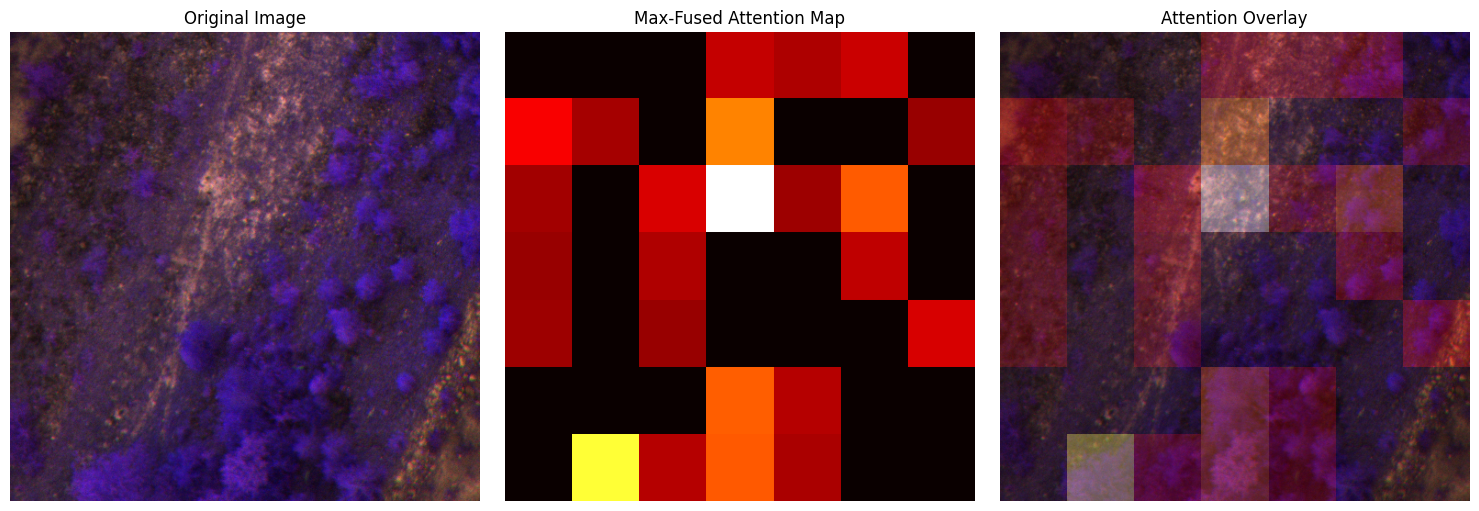

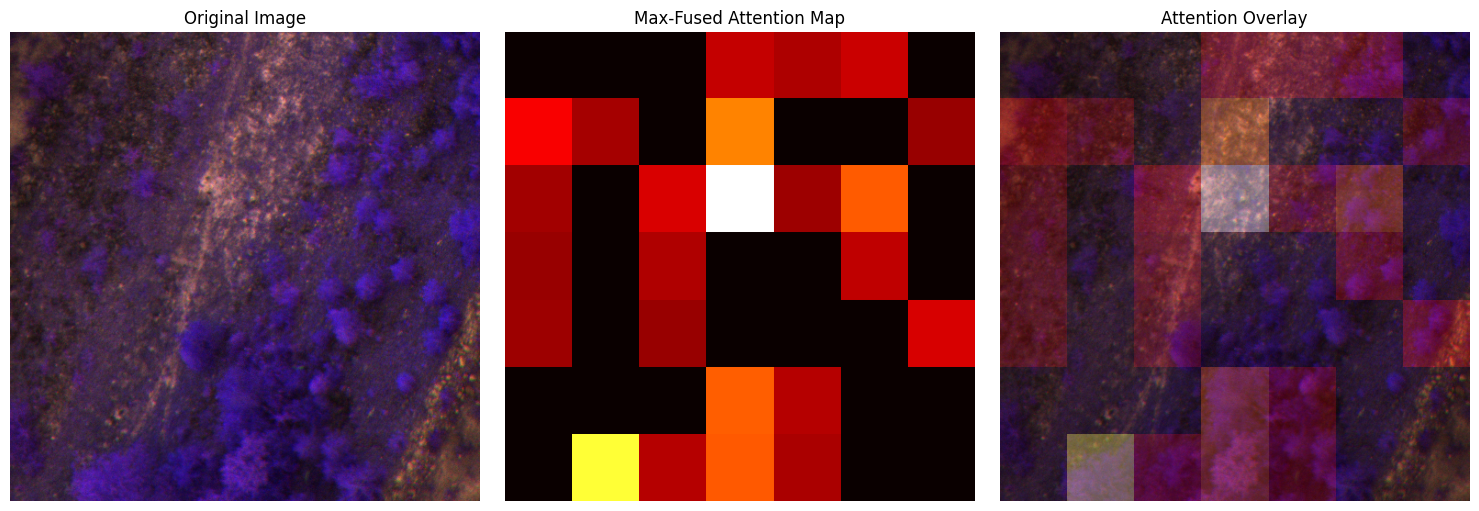

In [96]:
# Visualize attention
print("Visualizing attention...")
attention_rollout.visualize(input_tensor, original_image, save_path=output_path)

In [80]:
checkpoint = 
state_dict= torch.load(checkpoint)["state_dict"]
state_dict = clean_state_dict(state_dict, prefix_to_strip = "backbone.", skip_if_contains=["prediction_head", "projection_head"])

In [126]:


    
sample_url = 
x, img = load_tiff_tensor(sample_url, image_size=224)  # shape [1,4,224,224]


100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 11066.77it/s]


In [88]:
with torch.no_grad():
    feats = vit.forward_features(x)
    head = vit.forward_head(feats)
    out = vit(x)
    output, intermediates = vit.forward_intermediates(x)


In [94]:
import torch.nn.functional as F

In [127]:
#forward pass and extract the cls and attn stuff
y = vit(x)

attn_map = vit.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = vit.blocks[-1].attn.cls_attn_map.max(dim=1).values.view(14, 14).detach()

img_resized = x.squeeze(0).permute(1, 2, 0) * 0.5 + 0.5
cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)

In [129]:
# Extract attention maps and class scores from the model's blocks
from tqdm import tqdm
# Extract attention maps and class scores from the model's blocks
attn_maps = []
cls_weights = []
for block in tqdm(vit.blocks):
    attn_maps.append(block.attn.attn_map.max(dim=1).values.squeeze(0).detach())
    cls_weights.append(block.attn.cls_attn_map.mean(dim=1).view(14, 14).detach())

# Combine class scores of all blocks
cls_weight_combined = torch.prod(torch.stack(cls_weights), dim=0)
attn_maps_prod = torch.prod(torch.stack(attn_maps), dim=0)

100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 657.42it/s]


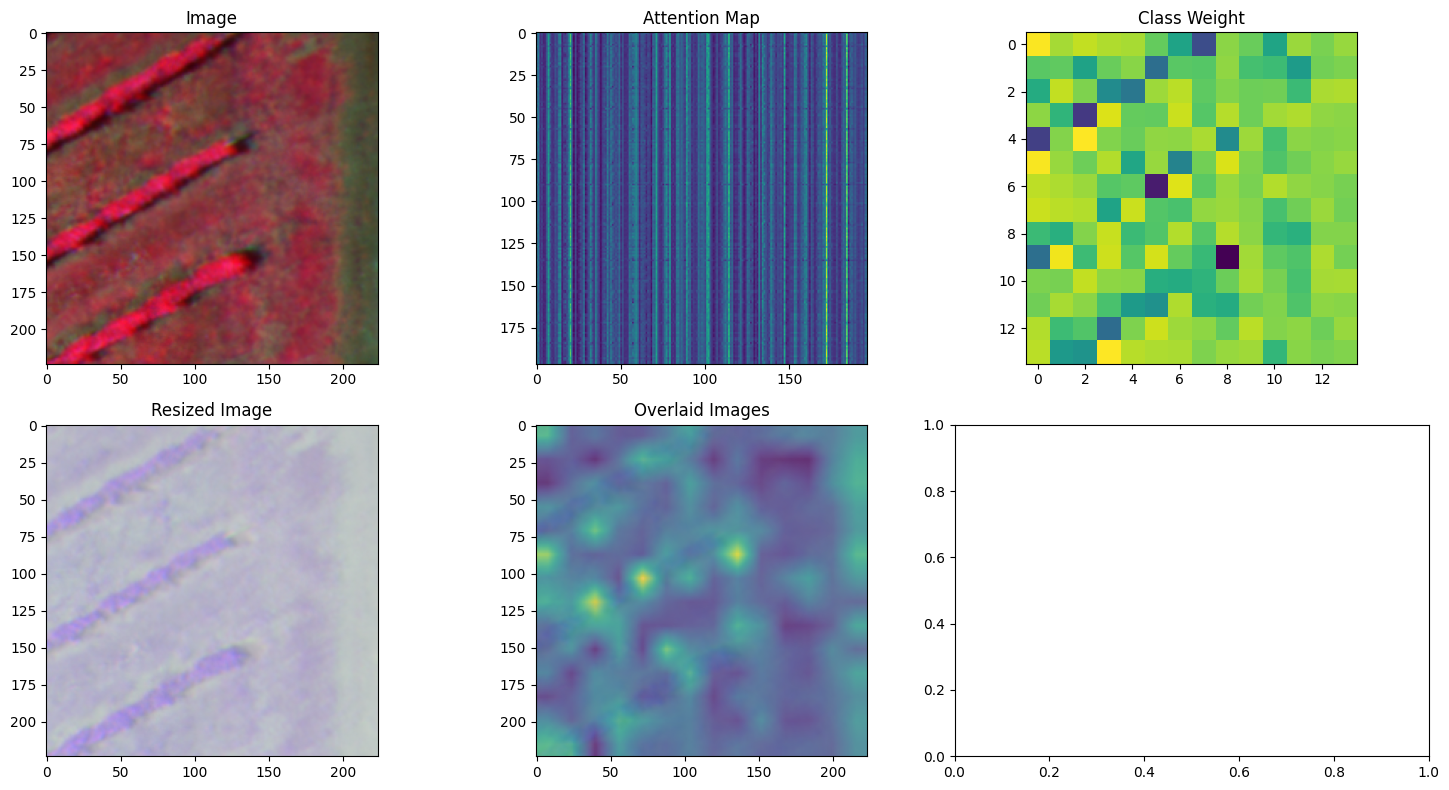

In [157]:
# Ensure tensors are on the CPU
attn_map_cpu = attn_map.cpu()
cls_weight_cpu = cls_weight.cpu()
cls_resized_cpu = cls_resized.cpu()

# Call the plot_set function with CPU tensors
plot_set(img[:,:,[3,1,0]], attn_map_cpu, cls_weight_cpu, img_resized, cls_resized_cpu)

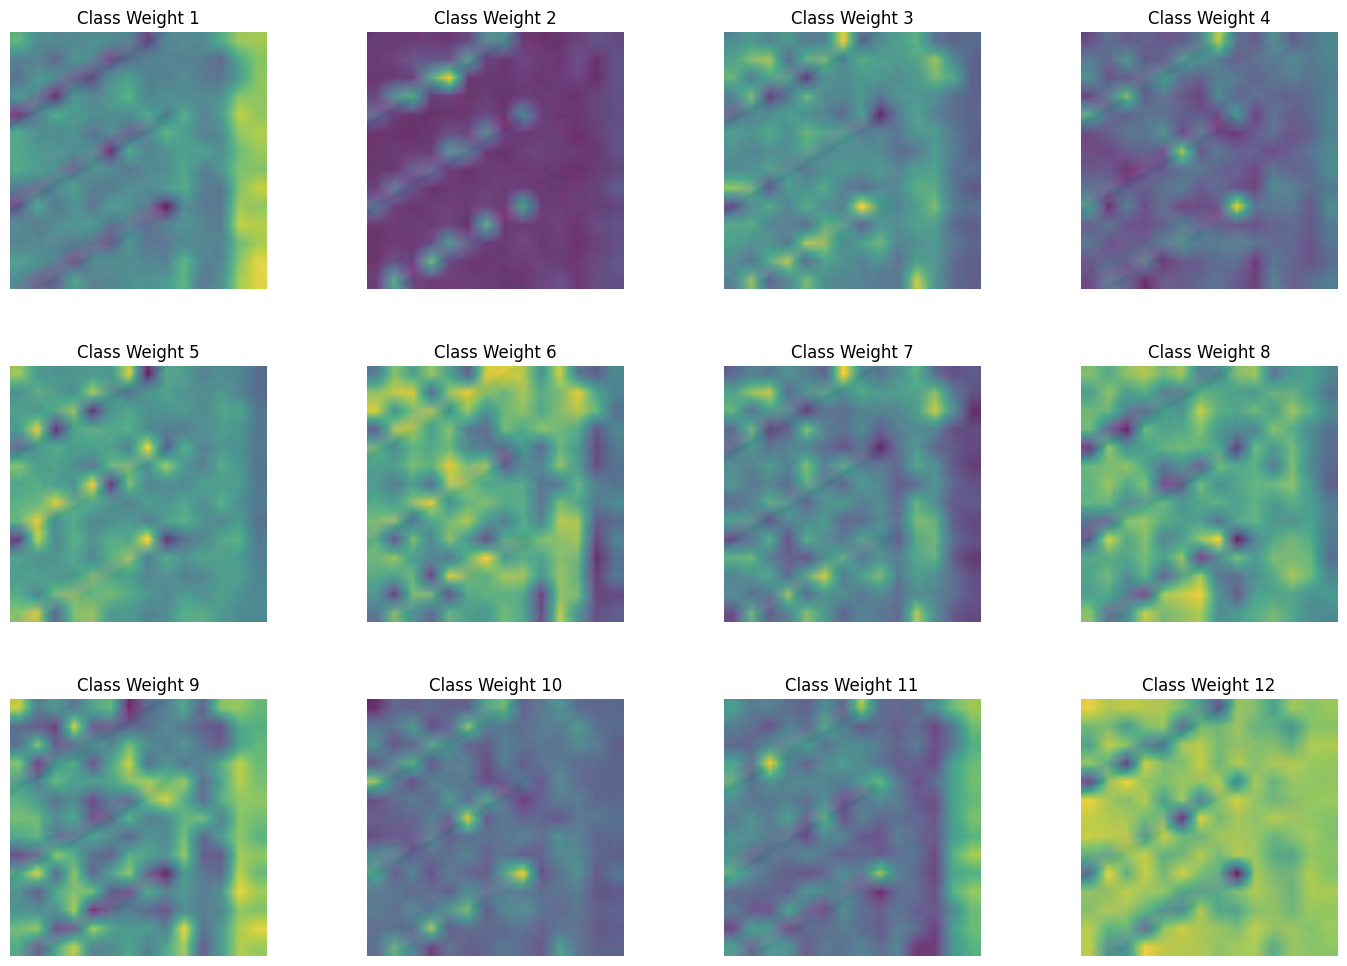

In [160]:
cls_weights_cpu = []
for i in range(12):
    cls_weight = cls_weights[i]
    cls_weight_cpu = cls_weight.cpu()
    cls_weights_cpu.append(cls_weight_cpu)
    
plot_cls_weights(cls_weights_cpu, img_resized[:,:,[3,1,0]])

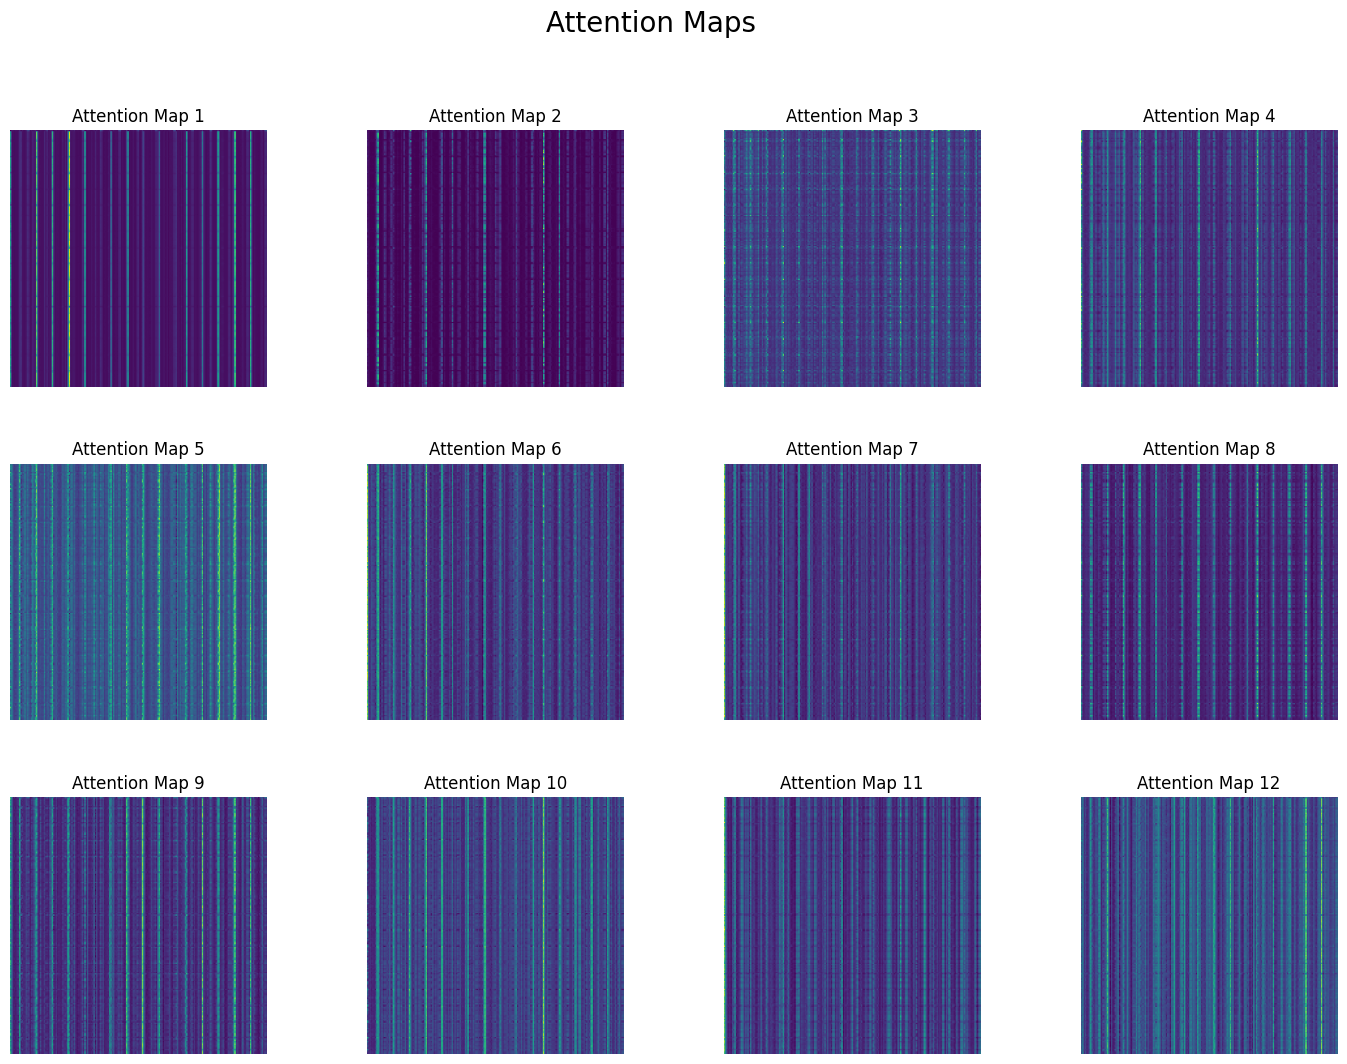

In [161]:
attn_maps_cpu = []
for i in range(12):
    attn_map = attn_maps[i]
    attn_map_cpu = attn_map.cpu()
    attn_maps_cpu.append(attn_map_cpu)
plot_attention_maps(attn_maps_cpu, num_cols=4)